# Time Series Forecasting

There are quite a few libraries for time series forecasting:
- [Darts](https://unit8co.github.io/darts/index.html)
- [GluonTS](https://ts.gluon.ai/stable/)
- [NeuralForecast](https://nixtla.mintlify.app/neuralforecast/index.html)
- [PyTorchForecasting](https://pytorch-forecasting.readthedocs.io/en/stable/)
- [Flow Forecast](https://flow-forecast.atlassian.net/wiki/spaces/FF/overview)

As their names suggest, the last three libraries focus on deep-learning
methods, while the first two libraries cover also traditional methods.
We will be using Darts in this notebook.


## A. Loading Data

First, let us import our data:

In [4]:
import pandas as pd
df = pd.read_csv("hk-export.csv")
df

,Year,Month,Imports,Exports
0,1952,Jan,385,197
1,1952,Feb,332,211
2,1952,Mar,284,240
3,1952,Apr,285,216
4,1952,May,301,232
...,...,...,...,...
856,2023,May,353959,327560
857,2023,Jun,393924,337350
858,2023,Jul,375143,345156
859,2023,Aug,383886,358294


Construct a time series index:

In [15]:
# Create date index
df["ym"] = df["Year"].astype(str) + " " + df["Month"]
df.index = pd.to_datetime(df["ym"],format="%Y %b")
df

,Year,Month,Imports,Exports,ym
ym,,,,,
1952-01-01,1952,Jan,385,197,1952 Jan
1952-02-01,1952,Feb,332,211,1952 Feb
1952-03-01,1952,Mar,284,240,1952 Mar
1952-04-01,1952,Apr,285,216,1952 Apr
1952-05-01,1952,May,301,232,1952 May
...,...,...,...,...,...
2023-05-01,2023,May,353959,327560,2023 May
2023-06-01,2023,Jun,393924,337350,2023 Jun
2023-07-01,2023,Jul,375143,345156,2023 Jul


Plot a chart of the exports data:

<Axes: xlabel='ym'>

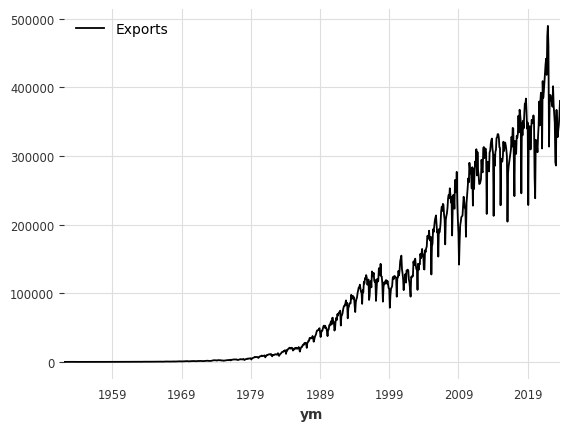

In [16]:
# Plot export against date
df.plot.line(y="Exports")

## B. Darts TimeSeries

The first step of using the Darts library is to convert our data into the library's `TimeSeries` format. The ones that are most relevant to us are:
- `TimeSeries.from_dataframe()` for Pandas `DataFrame`
- `TimeSeries.from_series()` for Pandas `Series`
- `TimeSeries.from_values()` for Numpy arrays

There are also methods to convert from CSV and JSON files. See the [documentation](https://unit8co.github.io/darts/generated_api/darts.timeseries.html) for details.

In [94]:
# Convert Pandas dataframe to Darts TimeSeries
from darts import TimeSeries
series = TimeSeries.from_dataframe(df,value_cols="Exports")

# Split the data into training and validation sets
train, val = series[:-36], series[-36:]



/opt/network/anaconda3/envs/pytorch/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Next we create a Darts model in a way that is similar to creating Scikit-Learn models. Darts provide us with many [models](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.html) to choose from.

In [ ]:
# Create Darts model
from darts.models import ExponentialSmoothing
model = ExponentialSmoothing()
model.fit(train)

Some models, like the `ExponentialSmoothing` model we are using, are probabilistic in nature, allowing us to generate multiple samples for each time period. 

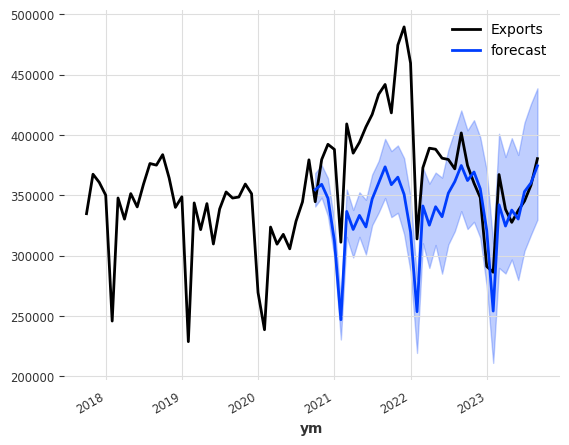

In [69]:
# Prediction is stored in time-dimension-samples format
prediction = model.predict(len(val), num_samples=100)

# Plot actual vs predicted values
import matplotlib.pyplot as plt

series[-72:].plot()
prediction[-72:].plot(label="forecast", low_quantile=0.05, high_quantile=0.95)
plt.legend()

Darts provide some common [metrics](https://unit8co.github.io/darts/generated_api/darts.metrics.metrics.html) for evaluating the model's performance:

In [70]:
# Mean absolute percentage error
from darts.metrics import smape
smapes = smape(prediction[-36:], val)
smapes

12.455829814727554

Now let us try using a neural network:

/opt/network/anaconda3/envs/pytorch/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/network/anaconda3/envs/pytorch/lib/python3.10/s ...
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 2.8 K 
4 | V             | Linear           | 26    
---------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

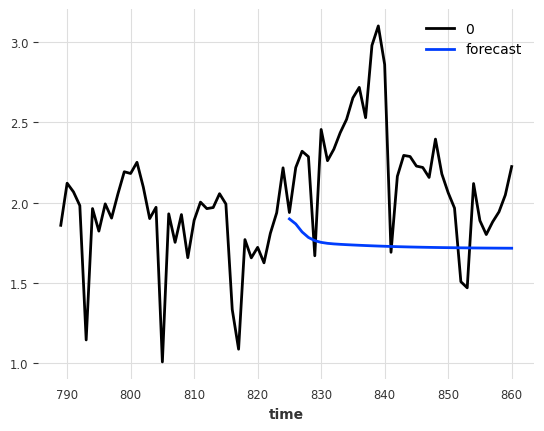

In [102]:
# Create Darts RNN model
from darts.models import RNNModel
model = RNNModel(model="LSTM",
                 input_chunk_length=6,
                 n_epochs=30)
model.fit(train)

prediction = model.predict(len(val))
series[-72:].plot()
prediction[-72:].plot(label="forecast")
plt.legend()

This looks pretty bad. Standardizing the data will help a little bit:

/opt/network/anaconda3/envs/pytorch/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/network/anaconda3/envs/pytorch/lib/python3.10/s ...
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 31.0 K
4 | V             | Linear           | 51    
---------------------------------------------------
31.1 K    Trainable params
0         Non-trainable params
31.1 K    Total params

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

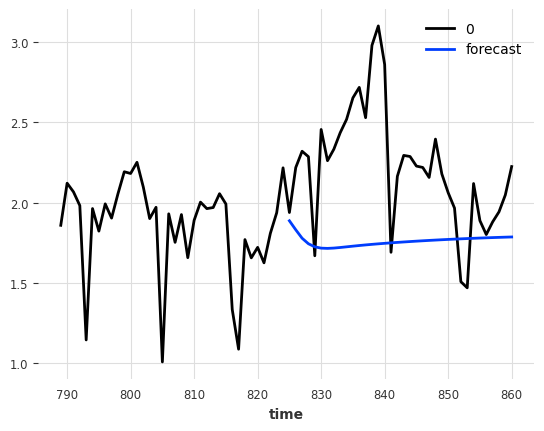

In [104]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
exports_std = scaler.fit_transform(df["Exports"].to_numpy().reshape(-1, 1))
series = TimeSeries.from_values(exports_std)

train, val = series[:-36], series[-36:]

# Create Darts RNN model
from darts.models import RNNModel
model = RNNModel(model="LSTM",
                 input_chunk_length=6,
                 training_length=18,
                 hidden_dim=50,
                 n_rnn_layers=2,
                 n_epochs=30)
model.fit(train)

prediction = model.predict(len(val))
series[-72:].plot()
prediction[-72:].plot(label="forecast")
plt.legend()

Let us try a model advanced model called [NBEATS](https://nixtla.mintlify.app/neuralforecast/models.nbeats.html):

/opt/network/anaconda3/envs/pytorch/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/network/anaconda3/envs/pytorch/lib/python3.10/s ...
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.1 M 
---------------------------------------------------
6.1 M     Trainable params
1.3 K     Non-trainable params
6.1 M     Total params
24.217    Total estimated model params size (

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=60` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

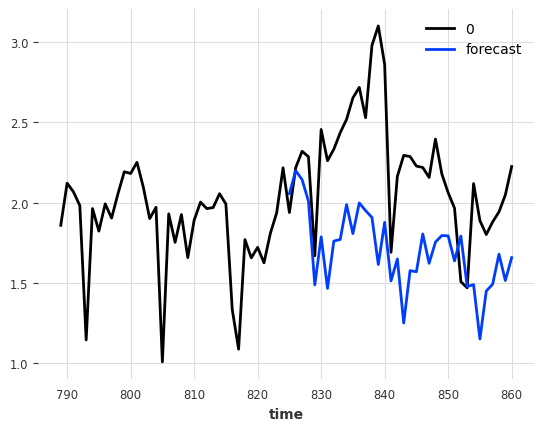

In [103]:
# Create Darts RNN model
from darts.models import NBEATSModel
model = NBEATSModel(input_chunk_length=6,
                    output_chunk_length=6,
                    n_epochs=60)
model.fit(train)

prediction = model.predict(len(val))
series[-72:].plot()
prediction[-72:].plot(label="forecast")
plt.legend()

Another popular model is [D-Linear](https://github.com/cure-lab/LTSF-Linear):

/opt/network/anaconda3/envs/pytorch/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/network/anaconda3/envs/pytorch/lib/python3.10/s ...
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params
-----------------------------------------------------
0 | criterion       | MSELoss          | 0     
1 | train_metrics   | MetricCollection | 0     
2 | val_metrics     | MetricCollection | 0     
3 | decomposition   | _SeriesDecomp    | 0     
4 | linear_seasonal | Linear           | 42    
5 | linear_trend    | Linear           | 42    
-----------------------------------------------------
84        Traina

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

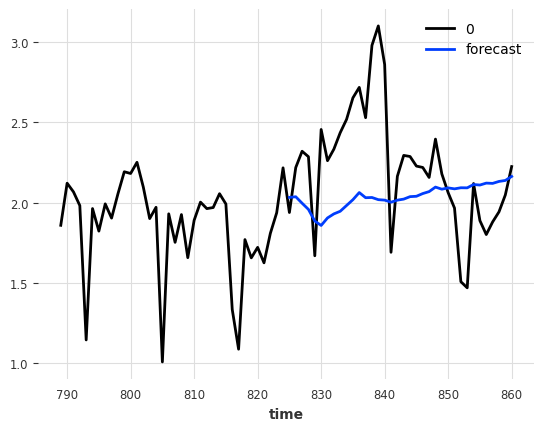

In [105]:
# Create Darts RNN model
from darts.models import DLinearModel
model = DLinearModel(input_chunk_length=6,
                    output_chunk_length=6,
                    n_epochs=30)
model.fit(train)

prediction = model.predict(len(val))
series[-72:].plot()
prediction[-72:].plot(label="forecast")
plt.legend()